Imports

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from lime.lime_tabular import LimeTabularExplainer
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.inspection import permutation_importance
import seaborn as sns

Definindo os datafra,es

In [8]:

df_train = pd.read_csv('/C-SSD/fachel/arthur/TRAB-AM-01/heartTrain.csv')
df_test = pd.read_csv('/C-SSD/fachel/arthur/TRAB-AM-01/heartTeste.csv')

In [9]:
mediana_colesterol = df_train['Cholesterol'].median()

Pré-processamento básico

In [10]:
y_train_full = df_train['HeartDisease']
X_test_final = df_test.drop('HeartDisease', axis=1, errors='ignore')
X_train_full = df_train.drop('HeartDisease', axis=1)
X_train_full['Cholesterol'].fillna(mediana_colesterol, inplace=True)

/tmp/ipykernel_3676287/1365690245.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train_full['Cholesterol'].fillna(mediana_colesterol, inplace=True)


In [11]:
categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
numeric_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

X_train_processed = pd.get_dummies(X_train_full, columns=categorical_cols, drop_first=True)
X_test_processed = pd.get_dummies(X_test_final, columns=categorical_cols, drop_first=True)
X_test_processed = X_test_processed.reindex(columns=X_train_processed.columns, fill_value=0)


In [12]:
standarScaler = StandardScaler()
X_train_processed[numeric_cols] = standarScaler.fit_transform(X_train_processed[numeric_cols])
X_test_processed[numeric_cols] = standarScaler.transform(X_test_processed[numeric_cols])

In [13]:
X_train_std, X_val_std, y_train_std, y_val_std = train_test_split(
    X_train_processed, y_train_full, test_size=0.3, random_state=42, stratify=y_train_full
)

Modelo, altere para testar as possiveis combinações

In [14]:
model = DecisionTreeClassifier(random_state=42, criterion='gini', max_depth=5, min_samples_split=10)


In [15]:
model.fit(X_train_std, y_train_std)
y_pred_std = model.predict(X_val_std)
accuracy_Std = accuracy_score(y_val_std, y_pred_std)
print(f"Acurácia do modelo com Standard: {accuracy_Std:.4f}")


Acurácia do modelo com Standard: 0.8370


==== LIME - Explicação da amostra ====
[('0.00 < ST_Slope_Up <= 1.00', -0.4824582450484781), ('ChestPainType_NAP <= 0.00', 0.1838218966860375), ('0.00 < ExerciseAngina_Y <= 1.00', 0.12154659019589036), ('Cholesterol <= -0.17', 0.11512532107908666), ('0.05 < MaxHR <= 0.71', -0.08857983233337581), ('-0.83 < Oldpeak <= -0.27', -0.07527489182457521), ('ChestPainType_TA <= 0.00', 0.04030105575597716), ('-0.13 < RestingBP <= 0.41', 0.015546126047660721), ('Age <= -0.66', 0.011231621796148564), ('RestingECG_Normal <= 0.00', 0.009972049143904843)]


/home/fachel/miniconda3/envs/pytorch/lib/python3.13/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/home/fachel/miniconda3/envs/pytorch/lib/python3.13/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/home/fachel/miniconda3/envs/pytorch/lib/python3.13/site-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels 

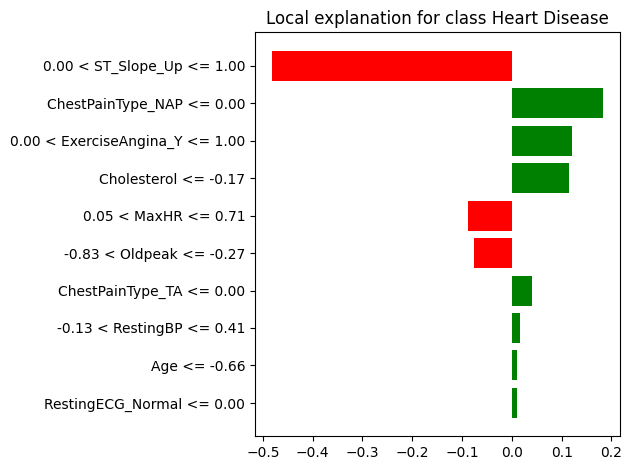

In [16]:
explainer = LimeTabularExplainer(
    training_data=np.array(X_train_std),
    feature_names=X_train_std.columns,
    class_names=['No Heart Disease', 'Heart Disease'],
    mode='classification'
)

# Explicação de uma amostra
idx = 0
exp = explainer.explain_instance(
    data_row=X_val_std.iloc[idx],
    predict_fn=model.predict_proba
)

print("==== LIME - Explicação da amostra ====")
print(exp.as_list())

# Para visualizar o gráfico da explicação:
fig = exp.as_pyplot_figure()
plt.tight_layout()
plt.show()


In [26]:
# Organizar em dataframe
perm_df = pd.DataFrame({
    'feature': X_val_std.columns,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values(by='importance_mean', ascending=False)


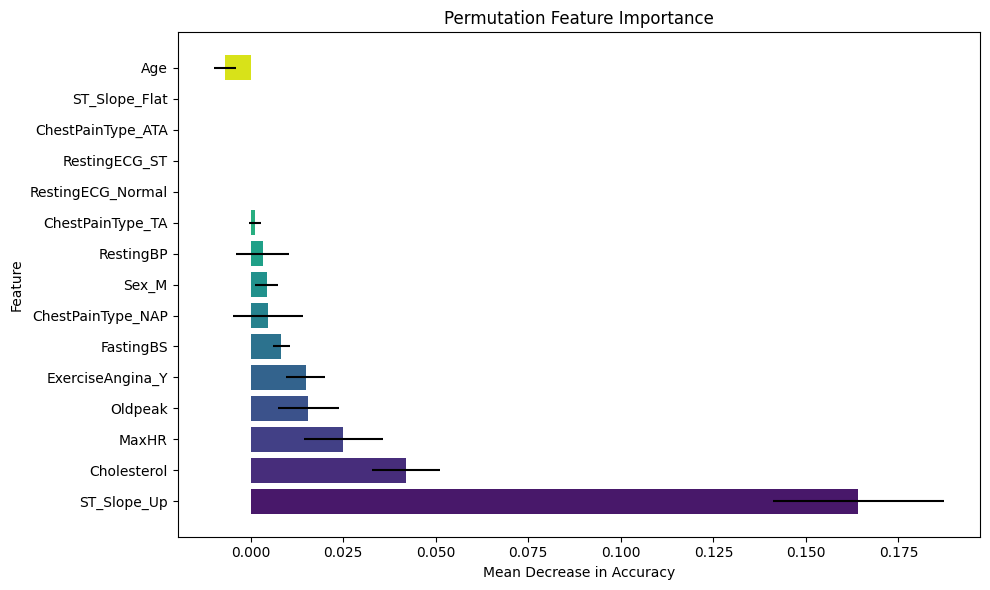

In [25]:
plt.figure(figsize=(10,6))
plt.barh(
    y=perm_df['feature'],
    width=perm_df['importance_mean'],
    xerr=perm_df['importance_std'],
    color=sns.color_palette("viridis", len(perm_df))
)
plt.xlabel("Mean Decrease in Accuracy")
plt.ylabel("Feature")
plt.title("Permutation Feature Importance")
plt.tight_layout()
plt.show()

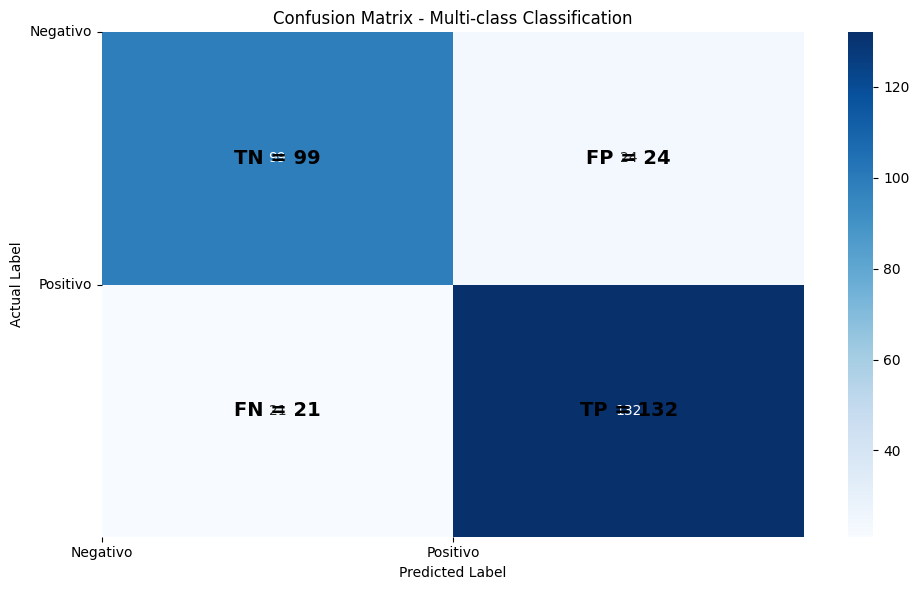

In [17]:
cm = confusion_matrix(y_val_std, y_pred_std)

# b) Criar o mapa de calor
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.title('Confusion Matrix - Multi-class Classification')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

class_names = ['Negativo', 'Positivo']
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks, class_names, rotation=0)

plt.text(0.5, 0.5, f'TN = {cm[0, 0]}', ha='center', va='center', color='black', fontsize=14, weight='bold')
plt.text(1.5, 0.5, f'FP = {cm[0, 1]}', ha='center', va='center', color='black', fontsize=14, weight='bold')
plt.text(0.5, 1.5, f'FN = {cm[1, 0]}', ha='center', va='center', color='black', fontsize=14, weight='bold')
plt.text(1.5, 1.5, f'TP = {cm[1, 1]}', ha='center', va='center', color='black', fontsize=14, weight='bold')

plt.tight_layout()
plt.show()

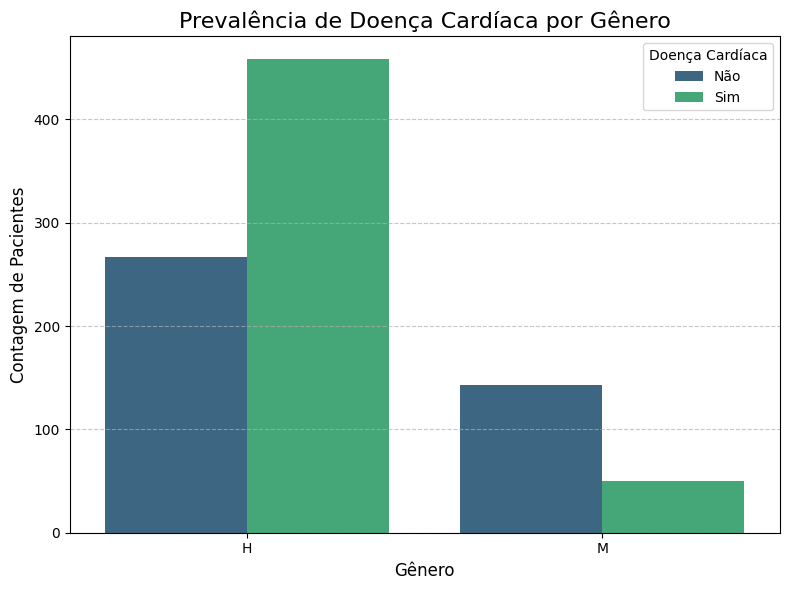

In [18]:

plt.figure(figsize=(8, 6))
sns.countplot(x='Sex', hue='HeartDisease', data=df_train, palette='viridis')
plt.title('Prevalência de Doença Cardíaca por Gênero', fontsize=16)
plt.xlabel('Gênero', fontsize=12)
plt.ylabel('Contagem de Pacientes', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['H', 'M'])
plt.legend(title='Doença Cardíaca', labels=['Não', 'Sim'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [19]:
contagem_por_sexo = df_test['Sex'].value_counts()

print("Contagem de pessoas por sexo:")
print(contagem_por_sexo)

Contagem de pessoas por sexo:
Sex
M    725
F    193
Name: count, dtype: int64
